In [1]:
import numpy as np
import pandas as pd

Import CSV files to read in data

In [2]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


# Feature Engineering

In order to compare tags and ratings I will make a new set that contains both, matching them based on movieId.The timestamps do not line up so it makes no sense to use them. The date that a user rates a movie should not have an affect on their preferences, and it shares no correlation with tags. 

In [6]:
ratingTag = ratings.drop(columns=['timestamp'])
part2 = tags.drop(columns=['timestamp'])
merged = pd.merge(ratingTag, part2, on = ["movieId", "userId"])
merged.head()

,userId,movieId,rating,tag
0,2,60756,5.0,funny
1,2,60756,5.0,Highly quotable
2,2,60756,5.0,will ferrell
3,2,89774,5.0,Boxing story
4,2,89774,5.0,MMA


I'm now going to sort these values based on ratings, to see which tags perform best/ gain highest rating. I only want to use highest ratings by individual users, since I won't pair them with a movie which they ranked low. I also merge my dataset with my third data set, again merging on MovieID as this will always be consistent for the same movie. 

In [7]:
merged = pd.merge(movies.drop(columns=['genres']), merged, on = ["movieId"])
merged = merged.sort_values(by='rating', ascending=False)
merged.head()

,movieId,title,userId,rating,tag
1738,4495,Crossing Delancey (1988),474,5.0,New York
2757,60069,WALL·E (2008),477,5.0,last man on earth
2739,58295,"Bank Job, The (2008)",537,5.0,robbery
2740,58295,"Bank Job, The (2008)",537,5.0,small time criminals
903,1307,When Harry Met Sally... (1989),474,5.0,New York


I am now going to label encode titles and tags so that I can put them into a k-means model. I am choosing to label encode rather than 1-hot encode because I care about which movie contains a certain set of ratings and tags, rather than if a movie contains ratings or tags. I only needed to label encode titles and tags because rating, userId, and movieId are already in numerical formats.

In [8]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
merged['tag'] = label_encoder.fit_transform(merged['tag'])
merged['title'] = label_encoder.fit_transform(merged['title'])
merged.head()

,movieId,title,userId,rating,tag
1738,4495,279,474,5.0,370
2757,60069,1381,477,5.0,1058
2739,58295,100,537,5.0,1299
2740,58295,100,537,5.0,1360
903,1307,1411,474,5.0,370


# Additional Value
By editing this data so that it may be clustered, it creates new value in 2 different ways:
1. This data can be used by companies like Netflix or Youtube, who make money by recommending videos/ music to you based on your previous views/ ratings. If they can figure out the next thing to show you, based on what you have watched in the past, you will spend more time using their service. For Netflix, this means renewing your subscription when it ends. For Youtube, it means you will spend additional time on their platform, watching more videos containing advertisements which generates them ad revenue. 
2. This can help movie makers create movies for their target markets. If they see that all of their viewers like a certain type of film/ tags, they can create movies that contain these attributes to keep their viewers coming back for more. 

# Clustering Model

Import pyplot to plot the data, make_blobs to separate my groups or "blobs" and KMeans in order to specify how many means to use in my K-means classification model. I am only using 2 features to make these blobs, ratings and tags. Essentially my model will see what tags earn high ratings from users, then identify other movies with similar tags and ratings. The actual movieId and title value do not matter in my classification model. I arbitrarily chose 50 centers because it appeared (when plotted) to give the nicest clustering representation of the data. 

In [9]:
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

X, _ = make_blobs(n_samples=1000, centers=50, n_features=2)

merged = pd.DataFrame(X, columns=['rating', 'tag'])

kmeans = KMeans(n_clusters=50)

y = kmeans.fit_predict(merged[['rating', 'tag']])

merged['Cluster'] = y

merged.head()

,rating,tag,Cluster
0,-8.616695,-0.577410,44
1,9.608268,0.254815,40
2,-10.773135,7.036549,4
3,5.400175,2.805591,9
4,-8.585876,8.784544,20


# Results

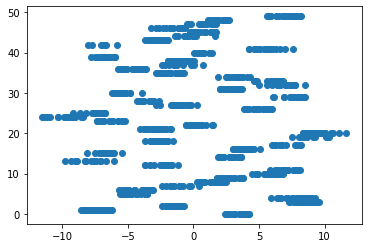

In [10]:
plt.scatter(merged['tag'], merged['Cluster'])

Above I have plotted my clusters of data. This groups movies based on their ratings and tags. In order to predict movies for a user to watch, find a movie that said user enjoys, find the cluster which contains that movie, and then recommend other movies within that cluster. This will ensure that the movie recommended to them has similar ratings and tags as the one they enjoyed. 